# GRU-T (time-aware GRU)

The original GRU model presents a major limitations when applied to our OSIC FVC time-series data:
It ignores unequal time intervals between measurements.
- A standard GRU processes sequences assuming each step occurs at a uniform time interval.
- Even if we include Weeks as a feature, the GRU’s recurrence is fundamentally unaware that:
    - the gap from week 1 → 3 is 2 weeks,
    - but the gap from week 3 → 7 is 4 weeks.
- Since the GRU update always proceeds in discrete, equally spaced steps, it fails to model the true temporal dynamics of lung function decline when time gaps vary across patients.

To address this limitation, we adopt GRU-T, a time-aware GRU variant designed for irregularly sampled clinical data.

GRU-T explicitly incorporates:
- `dt`: the time difference between the current and previous measurements, which allows the model to scale or decay the hidden state based on how much real time has passed

This makes the recurrence continuous-time–like, enabling the model to distinguish between short and long gaps in the patient’s timeline.

## Import libraries

In [244]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader


## Preprocess data & Feature engineering

In [ ]:
# Load the training data
df = pd.read_csv("../data/train.csv")
print(df.head())

print(df.groupby('Patient').size())

print("Missing values: ", df['Weeks'].isna().sum())  # checks for missing FVC values

df_test = pd.read_csv("../data/test.csv")

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
Patient
ID00007637202177411956430     9
ID00009637202177434476278     9
ID00010637202177584971671     9
ID00011637202177653955184     9
ID00012637202177665765362     9
                             ..
ID00419637202311204720264     9
ID00421637202311550012437    10
ID00422637202311677017371     8
ID00423637202312137826377     9
ID00426637202313170790466     9
Length: 176, dtype: int64
Missing values:  0


In [274]:
unique_ids = df["Patient"].unique()
test_ids = df_test["Patient"].unique()
unique_ids = [pid for pid in unique_ids if pid not in test_ids]
train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=3244)

In the preprocessing stage, we use the same process as GP but include additional step of doing feature engineering to create additional column `dt`, which controls how fast or slow the hidden state should forget or evolve.

Δt<sub>k</sub> ​= Weeks<sub>k</sub> ​− Weeks<sub>k−1​</sub>

In [275]:
# Same preprocessing as GP
df['Sex_id'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['Smk_id'] = df['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 1, 'Currently smokes': 2})

train_df = df[df['Patient'].isin(train_ids)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_ids)].reset_index(drop=True)


# Scale columns "Weeks" and "FVC"
time_scaler = StandardScaler()
fvc_scaler = StandardScaler()
train_df["Weeks_scaled"] = time_scaler.fit_transform(train_df[["Weeks"]])
train_df["FVC_scaled"] = fvc_scaler.fit_transform(train_df[["FVC"]])
val_df["Weeks_scaled"] = time_scaler.transform(val_df[["Weeks"]])
val_df["FVC_scaled"] = fvc_scaler.transform(val_df[["FVC"]])

# Calculate baseline FVC (scaled)
baseline_fvc_tr = train_df.groupby('Patient')['FVC_scaled'].first().to_dict()
baseline_fvc_val = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
train_df['Baseline_FVC'] = train_df['Patient'].map(baseline_fvc_tr)
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc_val)

# Sort by patient and weeks
train_df = train_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)
val_df = val_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)

# dt in raw weeks
train_df["dt"] = train_df.groupby("Patient")["Weeks"].diff().fillna(0.0)
val_df["dt"]   = val_df.groupby("Patient")["Weeks"].diff().fillna(0.0)

# dt in scaled weeks
train_df["dt_scaled"] = train_df.groupby("Patient")["Weeks_scaled"].diff().fillna(0.0)
val_df["dt_scaled"]   = val_df.groupby("Patient")["Weeks_scaled"].diff().fillna(0.0)


# Check the processed data
# print(val_df.head())
print(train_df.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Sex_id  Smk_id  Weeks_scaled  FVC_scaled  Baseline_FVC   dt  dt_scaled  
0       0       1     -1.511235   -0.401065     -0.401065  0.0   0.000000  
1       0       1     -1.123106   -0.515526     -0.401065  9.0   0.388130  
2       0       1     -1.036855   -0.688918     -0.401065  2.0   0.086251  
3       0       1     -0.950604   -0.594856     -0.401065  2.0   0.086251  
4       0       1     -0.864352   -0.679852     -0.401065  2.0   0.086251  


## Input Transformation for GRU-T

Input, Output Size

`X`:    (batch, T, F)

`dt`:   (batch, T)

------------->

`pred`: (batch, T, 1)     # FVC per time step


Helper function to build input sequences for GRU-T model

In [276]:
def build_sequences(df, feature_cols, target_col):
    X_seqs, week_seqs, dt_seqs, y_seqs = [], [], [], []
    patients = []

    for pid, g in df.groupby("Patient"):
        g = g.sort_values("Weeks")  # safety

        X = g[feature_cols].values.astype(np.float32)      # (T, F)
        dt = g["dt"].values.astype(np.float32)            # (T,)
        y = g[target_col].values.astype(np.float32)       # (T,)
        weeks = g["Weeks"].values.astype(np.float32)    # (T,)


        X_seqs.append(X)
        dt_seqs.append(dt)
        y_seqs.append(y)
        patients.append(pid)
        week_seqs.append(weeks)


    return X_seqs, dt_seqs, y_seqs, patients, week_seqs

Using the helper function, we build two sets of sequences, one for each model (M1 and M2), because they use different target variables and loss functions:
- M1 is trained to predict `FVC_scaled` (z-score of FVC).
    - It uses a standard regression loss such as MSE, which is well-defined in the scaled space.
- M2 is trained to predict raw `FVC` in mL.
    - It uses a Laplace negative log-likelihood loss with parameters μ (mean FVC) and σ (uncertainty in mL), so the target and the predicted μ,σ must be in the original raw FVC units.

In [277]:
feature_cols = [
    "Weeks_scaled",
    "Age",
    "Sex_id",
    "Smk_id",
    "Baseline_FVC"
    ]

target_col_M1 = "FVC_scaled"
target_col_M2 = "FVC"

# Build sequences for Model 1 (using FVC_scaled as target)
X_tr_seqs_M1, dt_tr_seqs_M1, y_tr_seqs_M1, train_patients_M1, weeks_tr_seqs_M1 = build_sequences(train_df, feature_cols, target_col_M1)
X_val_seqs_M1, dt_val_seqs_M1, y_val_seqs_M1, val_patients_M1, weeks_val_seqs_M1 = build_sequences(val_df, feature_cols, target_col_M1)

print(len(X_tr_seqs_M1), "train patients")
print("Example sequence shapes:", X_tr_seqs_M1[0].shape, dt_tr_seqs_M1[0].shape, y_tr_seqs_M1[0].shape)

# Build sequences for Model 2 (using raw FVC as target)
X_tr_seqs_M2, dt_tr_seqs_M2, y_tr_seqs_M2, train_patients_M2, weeks_tr_seqs_M2 = build_sequences(train_df, feature_cols, target_col_M2)
X_val_seqs_M2, dt_val_seqs_M2, y_val_seqs_M2, val_patients_M2, weeks_val_seqs_M2 = build_sequences(val_df, feature_cols, target_col_M2)

136 train patients
Example sequence shapes: (9, 5) (9,) (9,)


## GRU-T Model Implementation

Helper class to help us set up for the GRU-T model execution

In [278]:
class OSICSequenceDataset(Dataset):
    def __init__(self, X_seqs, dt_seqs, y_seqs):
        self.X_seqs = X_seqs
        self.dt_seqs = dt_seqs
        self.y_seqs = y_seqs

    def __len__(self):
        return len(self.X_seqs)

    def __getitem__(self, idx):
        X = torch.from_numpy(self.X_seqs[idx])          # (T, F)
        dt = torch.from_numpy(self.dt_seqs[idx])        # (T,)
        y = torch.from_numpy(self.y_seqs[idx])          # (T,)
        return X, dt, y


First, create a time-aware GRU cell that takes `dt` into account. 

**Intuitive understanding:**

In a standard GRU cell, it simply takes the previous hidden state and the current input, and combine them to make a new hidden state. In our time-aware GRU cell we want to make a slight modification such that if the next measurement happens much later (=> large `dt`), then information from the past should fade more. If it happened recently (=> small `dt`),then the past is still relevant so should not fade. 

The time-aware GRU cell uses `dt2decay`, a tiny neural network, to calculate how much hidden state should decay for that `dt`. Thus, for a large `dt` value, it will map to large decay rate and vice versa. Then, decay rate is turned into `gamma` ∈ [0,1], which acts as the forgetting strength. 
- `gamma` ≈ 1 → keep memory (small `dt`)
- `gamma` ≈ 0 → forget memory (large `dt`)

In [279]:
class TimeAwareGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # standard GRUCell
        self.gru_cell = nn.GRUCell(input_size, hidden_size)

        # map dt -> hidden_size decay rates
        self.dt2decay = nn.Linear(1, hidden_size)

    # add dt_t as input
    def forward(self, x_t, h_prev, dt_t):
        """
        x_t:   (batch, input_size)
        h_prev:(batch, hidden_size)
        dt_t:  (batch,) or (batch, 1)   # time gap since previous step
        """
        if dt_t.dim() == 1:
            dt_t = dt_t.unsqueeze(-1)    # (batch, 1)

        # ensure non-negative decay_rate, then gamma in (0,1]
        decay_rate = F.relu(self.dt2decay(dt_t))          # (batch, hidden_size)
        gamma = torch.exp(-decay_rate)                    # (batch, hidden_size)
        h_tilde = gamma * h_prev                          # decayed hidden state -> core of time-aware GRU

        # standard GRU update using decayed h
        h_new = self.gru_cell(x_t, h_tilde)               # (batch, hidden_size)
        return h_new


## GRU-T Model 1 (Output: FVC_scaled)

Then, we create an overall GRU-T network that incorporates the time-aware GRU cell built in the previous code. In the `GRUT` class, we basically perform the same GRU process but with newly defined cell. To ensure that we are processing all patients, each with different time sequence length, we won't combine them and feed the input as multiple batches at once, but train them separately setting the batch size into 1. 

Ultimately, GRUT will read a patient’s time series (their measurements over weeks) and walk through each time step, updating its internal “memory” of the patient at each week. It will use that memory to predict FVC at each week.

In [280]:
class GRUT1(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = TimeAwareGRUCell(input_size, hidden_size) 
        self.out = nn.Linear(hidden_size, 1)   # predict FVC (scaled)

    def forward(self, X, dt):
        """
        X:  (batch, T, F) -> use batch size of 1 to process different sequence lengths
        dt: (batch, T)
        Returns:
            preds: (batch, T, 1)
        """
        batch_size, T, F = X.shape
        device = X.device

        h = torch.zeros(batch_size, self.hidden_size, device=device) # initial hidden state of GRU -> no memory so start with zeros
        outputs = []

        for t in range(T):
            x_t = X[:, t, :]    # (batch, F) -> feature vector at time t (for all patients in batch)
            dt_t = dt[:, t]     # (batch,) -> dt at time t 
            h = self.cell(x_t, h, dt_t) # update hidden state by passing in current input, previous memory, and time gap (dt)
            outputs.append(h.unsqueeze(1))  # (batch, 1, H) -> [h_at_t0, h_at_t1, h_at_t2, ...]

        H_all = torch.cat(outputs, dim=1)       # (batch, T, H) -> stack all hidden states over time to make predictions
        preds = self.out(H_all)                 # (batch, T, 1) -> final FVC predictions
        return preds


Prepare the dataset for running the model

In [281]:
train_dataset_M1 = OSICSequenceDataset(X_tr_seqs_M1, dt_tr_seqs_M1, y_tr_seqs_M1)
val_dataset_M1   = OSICSequenceDataset(X_val_seqs_M1, dt_val_seqs_M1, y_val_seqs_M1)

# use batch_size=1 to handle variable-length sequences -> prevents padding
train_loader_M1 = DataLoader(train_dataset_M1, batch_size=1, shuffle=True)
val_loader_M1   = DataLoader(val_dataset_M1, batch_size=1, shuffle=False)

For training

In [282]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(feature_cols)
model1 = GRUT1(input_size=input_size, hidden_size=64).to(device)

optimizer_M1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
criterion = nn.MSELoss()  

def run_epoch_m1(loader, train=True):
    if train:
        model1.train() # for training dataset
    else:
        model1.eval() # for validation dataset

    total_loss = 0.0
    with torch.set_grad_enabled(train):
        for X, dt, y in loader: # one patient at a time
            # shapes: X:(1,T,F), dt:(1,T), y:(1,T) -> batch_size=1
            X = X.to(device)                  # (1, T, F)
            dt = dt.to(device)                # (1, T)
            y = y.to(device).unsqueeze(-1)    # (1, T, 1)

            preds = model1(X, dt)              # (1, T, 1)

            loss = criterion(preds, y)

            if train:
                optimizer_M1.zero_grad()
                loss.backward()
                optimizer_M1.step()

            total_loss += loss.item()

    return total_loss / len(loader)

## GRU-T Model 2 (output : mu, log_sigma)

In [283]:
class GRUT2(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = TimeAwareGRUCell(input_size, hidden_size) 
        self.out = nn.Linear(hidden_size, 2)   # output [mu, log_sigma]
        
    def forward(self, X, dt):
        """
        X:  (batch, T, F) -> use batch size of 1 to process different sequence lengths
        dt: (batch, T)
        Returns:
            preds: (batch, T, 1)
        """
        batch_size, T, F = X.shape
        device = X.device

        h = torch.zeros(batch_size, self.hidden_size, device=device) # initial hidden state of GRU -> no memory so start with zeros
        outputs = []

        for t in range(T):
            x_t = X[:, t, :]    # (batch, F) -> feature vector at time t (for all patients in batch)
            dt_t = dt[:, t]     # (batch,) -> dt at time t 
            h = self.cell(x_t, h, dt_t) # update hidden state by passing in current input, previous memory, and time gap (dt)
            outputs.append(h.unsqueeze(1))  # (batch, 1, H) -> [h_at_t0, h_at_t1, h_at_t2, ...]

        H_all = torch.cat(outputs, dim=1)       # (batch, T, H) -> stack all hidden states over time to make predictions
        preds = self.out(H_all)                 # (batch, T, 2) -> final mu, log_sigma predictions
        return preds


Negative Log Likelihood (NLL) for our loss function

In [284]:
def laplace_nll(y_true, y_pred):
    mu = y_pred[..., 0]
    log_sigma = y_pred[..., 1]
    sigma = F.softplus(log_sigma) + 1e-6
    diff = torch.abs(y_true[..., 0] - mu)
    loss = torch.log(2.0 * sigma) + diff / sigma
    return loss.mean()

In [285]:
train_dataset_M2 = OSICSequenceDataset(X_tr_seqs_M2, dt_tr_seqs_M2, y_tr_seqs_M2)
val_dataset_M2  = OSICSequenceDataset(X_val_seqs_M2, dt_val_seqs_M2, y_val_seqs_M2)

# use batch_size=1 to handle variable-length sequences -> prevents padding
train_loader_M2 = DataLoader(train_dataset_M2, batch_size=1, shuffle=True)
val_loader_M2   = DataLoader(val_dataset_M2, batch_size=1, shuffle=False)

In [286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(feature_cols)
model2 = GRUT2(input_size=input_size, hidden_size=64).to(device)

optimizer_M2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

def run_epoch_m2(loader, train=True):
    if train:
        model2.train() # for training dataset
    else:
        model2.eval() # for validation dataset

    total_loss = 0.0
    with torch.set_grad_enabled(train):
        for X, dt, y in loader: # one patient at a time
            # shapes: X:(1,T,F), dt:(1,T), y:(1,T) -> batch_size=1
            X = X.to(device)                  # (1, T, F)
            dt = dt.to(device)                # (1, T)
            y = y.to(device).unsqueeze(-1)    # (1, T, 1)

            preds = model2(X, dt)              # (1, T, 2) -> [mu, log_sigma]

            loss = laplace_nll(y, preds)

            if train:
                optimizer_M2.zero_grad()
                loss.backward()
                optimizer_M2.step()

            total_loss += loss.item()

    return total_loss / len(loader)

## Hyperparameter fine-tuning

Helper function to find the best epoch

In [287]:
def best_epoch(model_name, train_loader,val_loader, model, optimizer, num_epochs=500, patience=20):
    optimizer.zero_grad()

    best_val_loss = float('inf')
    best_epoch = -1
    best_state = None
    train_losses = []
    val_losses = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        if model_name == "M1":
            train_loss = run_epoch_m1(train_loader, train=True)
            val_loss   = run_epoch_m1(val_loader, train=False)
        else:  # model_name == "M2"
            train_loss = run_epoch_m2(train_loader, train=True)
            val_loss   = run_epoch_m2(val_loader, train=False)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            best_state = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": best_epoch
            }
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return best_epoch, best_state, train_losses, val_losses

To optimise our model, we want to find the optimal number of epochs for both our M1 and M2. 

In [288]:
best_epoch_M1, best_state_M1, train_losses_M1, val_losses_M1 = best_epoch("M1", train_loader_M1, val_loader_M1, model1, optimizer_M1, num_epochs=100, patience=50)
best_epoch_M2, best_state_M2, train_losses_M2, val_losses_M2 = best_epoch("M2", train_loader_M2, val_loader_M2, model2, optimizer_M2, num_epochs=500, patience=50)

Epoch 01 | train_loss=0.9747 | val_loss=0.4661
Epoch 02 | train_loss=0.4602 | val_loss=0.1192
Epoch 03 | train_loss=0.1603 | val_loss=0.0767
Epoch 04 | train_loss=0.1245 | val_loss=0.0727
Epoch 05 | train_loss=0.1011 | val_loss=0.0877
Epoch 06 | train_loss=0.0844 | val_loss=0.0910
Epoch 07 | train_loss=0.0949 | val_loss=0.0539
Epoch 08 | train_loss=0.0821 | val_loss=0.0679
Epoch 09 | train_loss=0.0849 | val_loss=0.0598
Epoch 10 | train_loss=0.0808 | val_loss=0.0547
Epoch 11 | train_loss=0.0724 | val_loss=0.0558
Epoch 12 | train_loss=0.0788 | val_loss=0.0618
Epoch 13 | train_loss=0.0747 | val_loss=0.0910
Epoch 14 | train_loss=0.0759 | val_loss=0.0552
Epoch 15 | train_loss=0.0781 | val_loss=0.0933
Epoch 16 | train_loss=0.0717 | val_loss=0.0664
Epoch 17 | train_loss=0.0716 | val_loss=0.0552
Epoch 18 | train_loss=0.0766 | val_loss=0.1647
Epoch 19 | train_loss=0.0721 | val_loss=0.0639
Epoch 20 | train_loss=0.0663 | val_loss=0.0612
Epoch 21 | train_loss=0.0754 | val_loss=0.0530
Epoch 22 | tr

Plot the training and validation loss for each iteration

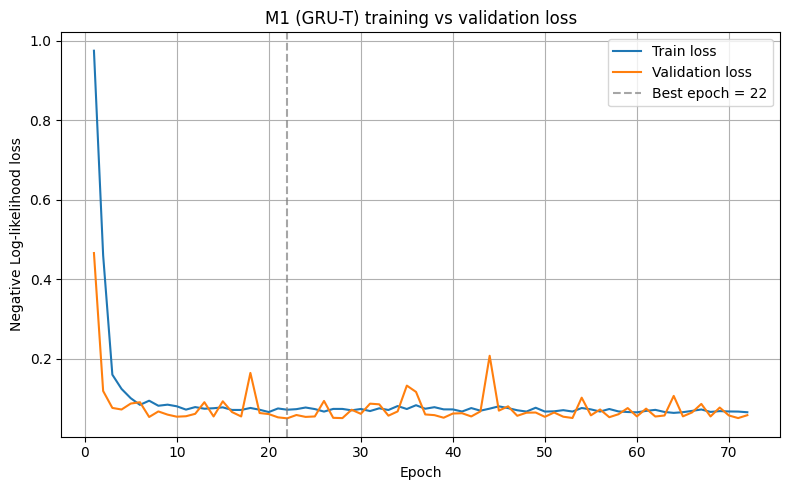

In [290]:
num_epochs_M1 = len(train_losses_M1)
epochs_M1 = range(1, num_epochs_M1 + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_M1, train_losses_M1, label="Train loss")
plt.plot(epochs_M1, val_losses_M1,   label="Validation loss")
plt.axvline(best_epoch_M1, color="gray", linestyle="--", alpha=0.7,
            label=f"Best epoch = {best_epoch_M1}")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-likelihood loss")
plt.title("M1 (GRU-T) training vs validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

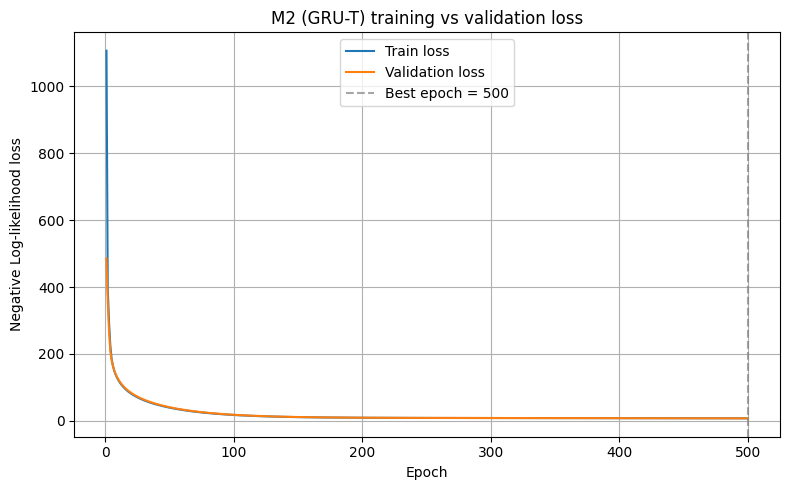

In [291]:
num_epochs_M2 = len(train_losses_M2)
epochs_M2 = range(1, num_epochs_M2 + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_M2, train_losses_M2, label="Train loss")
plt.plot(epochs_M2, val_losses_M2,   label="Validation loss")
plt.axvline(best_epoch_M2, color="gray", linestyle="--", alpha=0.7,
            label=f"Best epoch = {best_epoch_M2}")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-likelihood loss")
plt.title("M2 (GRU-T) training vs validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

### **Model 1** (FVC_scaled predictions)

In [294]:
from sklearn.metrics import mean_absolute_error, r2_score

def eval_mae_r2_M1(model1, loader, device, fvc_scaler):
    """
    model1: GRU or any model producing FVC_scaled (shape: (1,T,1))
    loader: DataLoader returning (X, dt, y_scaled)
    fvc_scaler: StandardScaler used to scale FVC
    """
    model1.eval()

    true_scaled_all = []
    pred_scaled_all = []

    with torch.no_grad():
        for X, dt, y_scaled in loader:
            X = X.to(device)            # (1, T, F)
            dt = dt.to(device)          # (1, T)

            y_scaled = y_scaled.squeeze(0).cpu().numpy()   # (T,)

            preds = model1(X, dt)                            # (1, T, 1)
            preds = preds.squeeze(0).squeeze(-1).cpu().numpy()  # (T,)

            true_scaled_all.extend(y_scaled.tolist())
            pred_scaled_all.extend(preds.tolist())

    # convert to arrays
    true_scaled_all = np.array(true_scaled_all)
    pred_scaled_all = np.array(pred_scaled_all)

    # ===== Metrics in scaled FVC space =====
    mae_scaled = mean_absolute_error(true_scaled_all, pred_scaled_all)
    r2_scaled  = r2_score(true_scaled_all, pred_scaled_all)
    rmse_scaled = np.sqrt(np.mean((true_scaled_all - pred_scaled_all) ** 2))

    # ===== Convert to RAW FVC in mL =====
    true_raw = fvc_scaler.inverse_transform(true_scaled_all.reshape(-1,1)).ravel()
    pred_raw = fvc_scaler.inverse_transform(pred_scaled_all.reshape(-1,1)).ravel()

    mae_raw = mean_absolute_error(true_raw, pred_raw)
    r2_raw  = r2_score(true_raw, pred_raw)
    rmse_raw = np.sqrt(np.mean((true_raw - pred_raw) ** 2))


    return {
        "mae_scaled": mae_scaled,
        "r2_scaled": r2_scaled,
        "rmse_scaled": rmse_scaled,
        "mae_raw": mae_raw,
        "rmse_raw": rmse_raw,
        "r2_raw": r2_raw,
    }

metrics_train_M1 = eval_mae_r2_M1(model1, train_loader_M1, device, fvc_scaler)
metrics_val_M1   = eval_mae_r2_M1(model1, val_loader_M1, device, fvc_scaler)

print("=== M1 TRAIN ===")
print("MAE (scaled):", metrics_train_M1["mae_scaled"])
print("R2   (scaled):", metrics_train_M1["r2_scaled"])
print("RMSE (scaled):", metrics_train_M1["rmse_scaled"])
print("MAE (mL):", metrics_train_M1["mae_raw"])
print("R2   (mL):", metrics_train_M1["r2_raw"])
print("RMSE (mL):", metrics_train_M1["rmse_raw"])

print("\n=== M1 VAL ===")
print("MAE (scaled):", metrics_val_M1["mae_scaled"])
print("R2   (scaled):", metrics_val_M1["r2_scaled"])
print("RMSE (scaled):", metrics_val_M1["rmse_scaled"])
print("MAE (mL):", metrics_val_M1["mae_raw"])
print("R2   (mL):", metrics_val_M1["r2_raw"])
print("RMSE (mL):", metrics_val_M1["rmse_raw"])


=== M1 TRAIN ===
MAE (scaled): 0.1684517562039348
R2   (scaled): 0.9420473566957395
RMSE (scaled): 0.24073355214228695
MAE (mL): 148.64102833981207
R2   (mL): 0.9420473566957395
RMSE (mL): 212.42214122721902

=== M1 VAL ===
MAE (scaled): 0.16252291457306955
R2   (scaled): 0.8943382846637038
RMSE (scaled): 0.24239349474946167
MAE (mL): 143.40944668857185
R2   (mL): 0.8943382846637038
RMSE (mL): 213.886866687349


In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_patient_pred(model_name, model, dataset, weeks_seqs, idx):
    """
    Returns weeks, true FVC (scaled), predicted FVC (scaled) for one patient.
    """
    model.eval()

    X, dt, y = dataset[idx]          # X:(T,F), dt:(T,), y:(T,)
    weeks = weeks_seqs[idx]          # (T,)

    # add batch dimension: (1,T,F), (1,T)
    X_in = X.unsqueeze(0).to(device)
    dt_in = dt.unsqueeze(0).to(device)

    if model_name == "M1":
        with torch.no_grad():
            pred_scaled = model(X_in, dt_in)                      # (1,T,1)
            pred_scaled = pred_scaled.cpu().numpy().reshape(-1)   # (T,)

        true_scaled = y.numpy().reshape(-1)                       # (T,)
        return weeks, true_scaled, pred_scaled
    else: # for M2
        with torch.no_grad():
            preds = model(X_in, dt_in)             # (1,T,2)
            mu = preds[..., 0].squeeze(0)          # (T,)
            log_sigma = preds[..., 1].squeeze(0)   # (T,)
            sigma = F.softplus(log_sigma) + 1e-6   # (T,)
        
        mu_raw = mu.cpu().numpy()            # (T,)
        sigma_raw = sigma.cpu().numpy()      # (T,)
        true_raw = y.numpy().reshape(-1)     # (T,)

        return weeks, true_raw, mu_raw, sigma_raw

In [296]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_patient_pred_scaled(model, dataset, weeks_seqs, idx):
    """
    Returns weeks, true FVC (scaled), predicted FVC (scaled) for one patient.
    """
    model.eval()

    X, dt, y = dataset[idx]          # X:(T,F), dt:(T,), y:(T,)
    weeks = weeks_seqs[idx]          # (T,)

    # add batch dimension: (1,T,F), (1,T)
    X_in = X.unsqueeze(0).to(device)
    dt_in = dt.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_scaled = model(X_in, dt_in)      # (1,T,1)

    pred_scaled = pred_scaled.cpu().numpy().reshape(-1)  # (T,)
    true_scaled = y.numpy().reshape(-1)                  # (T,)

    return weeks, true_scaled, pred_scaled


In [297]:
def plot_grut_grid_M1(model, dataset, weeks_seqs, patient_ids, indices=None, n_rows=2, n_cols=5, ci_dict=None):

    model.eval()

    figsize=(18, 6)

    n_plots = n_rows * n_cols

    if indices is None:
        indices = list(range(min(n_plots, len(dataset))))
    else:
        indices = indices[:n_plots]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        pid = patient_ids[idx]
        weeks, true_fvc_scaled, pred_fvc_scaled = get_patient_pred(
            "M1", model, dataset, weeks_seqs, idx
        )

        # true FVC (scaled)
        ax.plot(
            weeks, true_fvc_scaled,
            marker="o", color="C0",
            label="True FVC" if idx == indices[0] else None
        )

        # GRU-T predicted FVC (scaled)
        ax.plot(
            weeks, pred_fvc_scaled,
            marker="s", linestyle="--", color="C1",
            label="Predicted FVC" if idx == indices[0] else None
        )

        ax.set_title(f"Patient {pid[:8]}...")
        ax.set_xlabel("Weeks")
        ax.set_ylabel("FVC (scaled)")
        ax.grid(True)

    # Put shared legend in first axes (or figure-level)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()


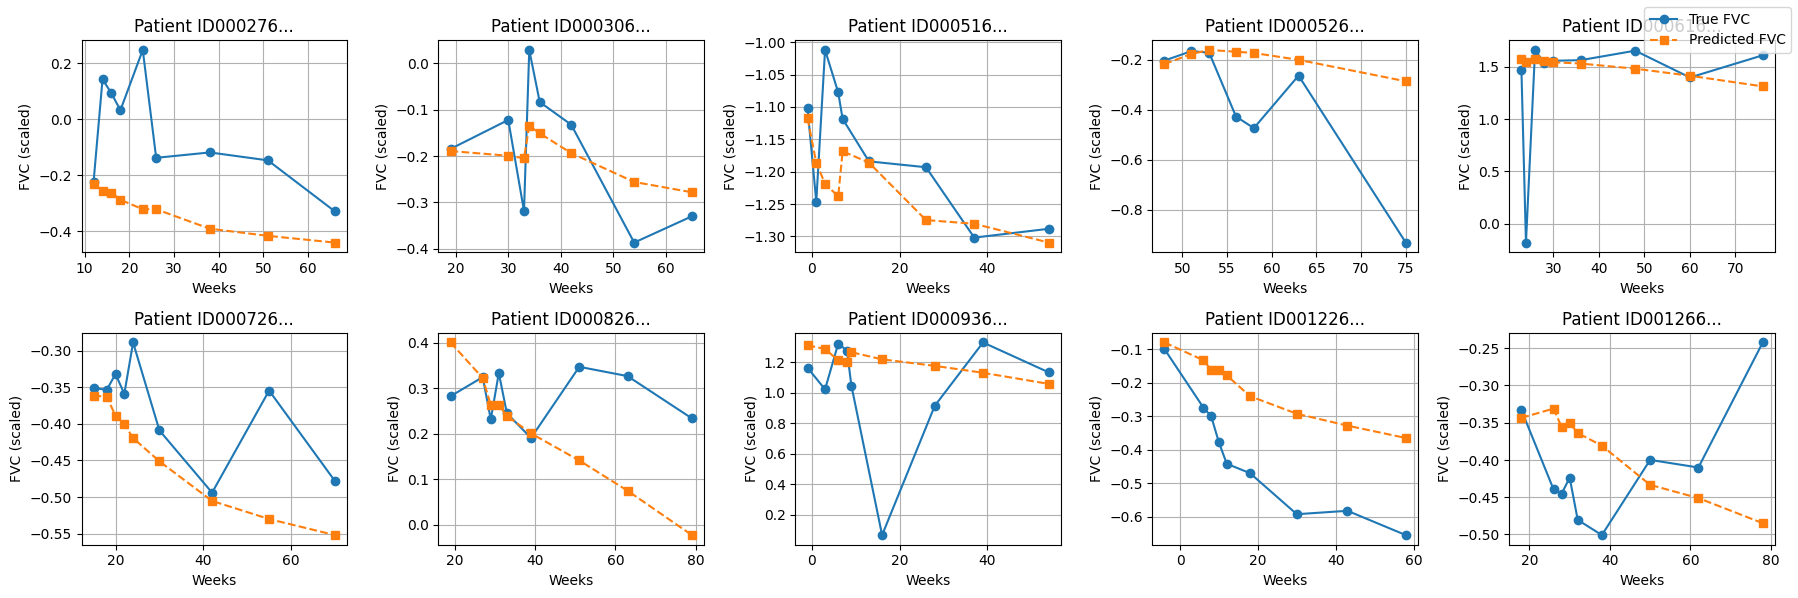

In [298]:
plot_grut_grid_M1(
    model=model1,
    dataset=val_dataset_M1,
    weeks_seqs= weeks_val_seqs_M1,
    patient_ids=val_patients_M1,
    n_rows=2,
    n_cols=5,
    ci_dict=None)

### **Model 2** (mu, log_sigma)

### Helper functions to calculate metrics 

In [299]:
def laplace_log_likelihood(y_true, y_pred, sigma):
    sigma_clipped = np.maximum(sigma, 70)
    delta_clipped = np.minimum(np.abs(y_true - y_pred), 1000)
    score = - np.sqrt(2) * delta_clipped / sigma_clipped - np.log(np.sqrt(2) * sigma_clipped)
    return np.mean(score)

In [300]:
def get_mu_sigma(model, X, dt):
    model.eval()
    with torch.no_grad():
        preds = model(X, dt)          # (1, T, 2)
        mu_t = preds[..., 0]          # (1, T)
        log_sigma_t = preds[..., 1]   # (1, T)

        # numerically stable softplus in torch (avoid overflow) -> without this the laplace score might be -inf
        sigma_t = F.softplus(log_sigma_t) + 1e-6   # (1, T)

    mu = mu_t.squeeze(0).cpu().numpy()             # (T,)
    sigma = sigma_t.squeeze(0).cpu().numpy()       # (T,)

    return mu, sigma

In [301]:
def eval_lapace_on_loader(model, loader, device):
    model.eval()
    scores = []

    with torch.no_grad():
        for X, dt, y in loader:
            # X: (1, T, F), dt: (1, T), y: (1, T)
            X = X.to(device)
            dt = dt.to(device)

            # y is target FVC in mL
            y_true = y.squeeze(0).cpu().numpy()   # (T,)

            # get mu, sigma from the model
            mu, sigma = get_mu_sigma(model, X, dt)  # both (T,)

            # compute laplace log likelihood for this patient
            score = laplace_log_likelihood(
                y_true=y_true,
                y_pred=mu,
                sigma=sigma
            )
            scores.append(score)

    # mean OSIC score across all patients in this loader
    return float(np.mean(scores))


In [302]:
from sklearn.metrics import mean_absolute_error, r2_score

def eval_mae_r2(model, loader, device):
    model.eval()

    all_true = []
    all_pred = []

    with torch.no_grad():
        for X, dt, y in loader:
            X = X.to(device)        # (1, T, F)
            dt = dt.to(device)      # (1, T)

            y_true = y.squeeze(0).cpu().numpy()       # (T,)

            # get predicted mu
            mu, _ = get_mu_sigma(model, X, dt)   # mu: (T,)

            all_true.extend(y_true.tolist())
            all_pred.extend(mu.tolist())

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    mae = mean_absolute_error(all_true, all_pred)
    r2 = r2_score(all_true, all_pred)

    return mae, r2


### Evaluation with metrics

In [303]:
model2.eval()

train_osic = eval_lapace_on_loader(model2, train_loader_M2, device)
val_osic   = eval_lapace_on_loader(model2, val_loader_M2, device)

print(f"Train Laplace Log Likelihood score: {train_osic:.4f}")
print(f"Val Laplace Log Likelihood score: {val_osic:.4f}")

train_mae, train_r2 = eval_mae_r2(model2, train_loader_M2, device)
val_mae, val_r2     = eval_mae_r2(model2, val_loader_M2, device)

print("\nTrain R2:", train_r2)
print("Val R2:", val_r2)

print("\nTrain MAE:", train_mae)
print("Val MAE:", val_mae)


Train Laplace Log Likelihood score: -7.3647
Val Laplace Log Likelihood score: -7.3300

Train R2: 0.4694719831093941
Val R2: 0.45627471148904486

Train MAE: 392.54304542733195
Val MAE: 331.51736942414317


In [308]:
def plot_grut_grid_M2(model, dataset, weeks_seqs, patient_ids, indices=None, n_rows=2, n_cols=5, ci=1.96):
    """
    Plots a grid of GRU-T predictions (μ ± CI·σ) for multiple patients.

    Parameters
    ----------
    model         : GRU-T model (predicts (mu, logsigma))
    dataset       : Dataset returning (X, dt, y_raw)
    weeks_seqs    : list of arrays of week indices per patient
    patient_ids   : list of patient IDs
    fvc_scaler    : StandardScaler for FVC (optional)
                    - if provided → convert raw FVC to scaled
                    - if None     → plot raw FVC in mL
    indices       : list of patient indices to plot
    ci            : float, confidence interval multiplier
    """

    model.eval()

    figsize = (18, 6)
    n_plots = n_rows * n_cols

    if indices is None:
        indices = list(range(min(n_plots, len(dataset))))
    else:
        indices = indices[:n_plots]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        pid = patient_ids[idx]

        # Weeks, true_y, mu, sigma (scaled or raw depending on fvc_scaler)
        weeks, true_fvc, pred_mu, sigma = get_patient_pred(
            model_name="M2",
            model=model,
            dataset=dataset,
            weeks_seqs=weeks_seqs,
            idx=idx
        )

        # Confidence interval bounds
        upper = pred_mu + ci * sigma
        lower = pred_mu - ci * sigma

        # CI shaded area
        ax.fill_between(
            weeks, lower, upper,
            color="C0", alpha=0.15,
            label="95% CI" if idx == indices[0] else None
        )

        # true FVC
        ax.plot(
            weeks, true_fvc,
            marker="o", color="C0",
            label="True FVC" if idx == indices[0] else None
        )

        # predicted mean FVC
        ax.plot(
            weeks, pred_mu,
            marker="s", linestyle="--", color="C1",
            label="Predicted FVC" if idx == indices[0] else None
        )

        ax.set_title(f"Patient {pid[:8]}...")
        ax.set_xlabel("Weeks")

        ylabel = "FVC (scaled)" if fvc_scaler is not None else "FVC (mL)"
        ax.set_ylabel(ylabel)

        ax.grid(True)

    # shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()


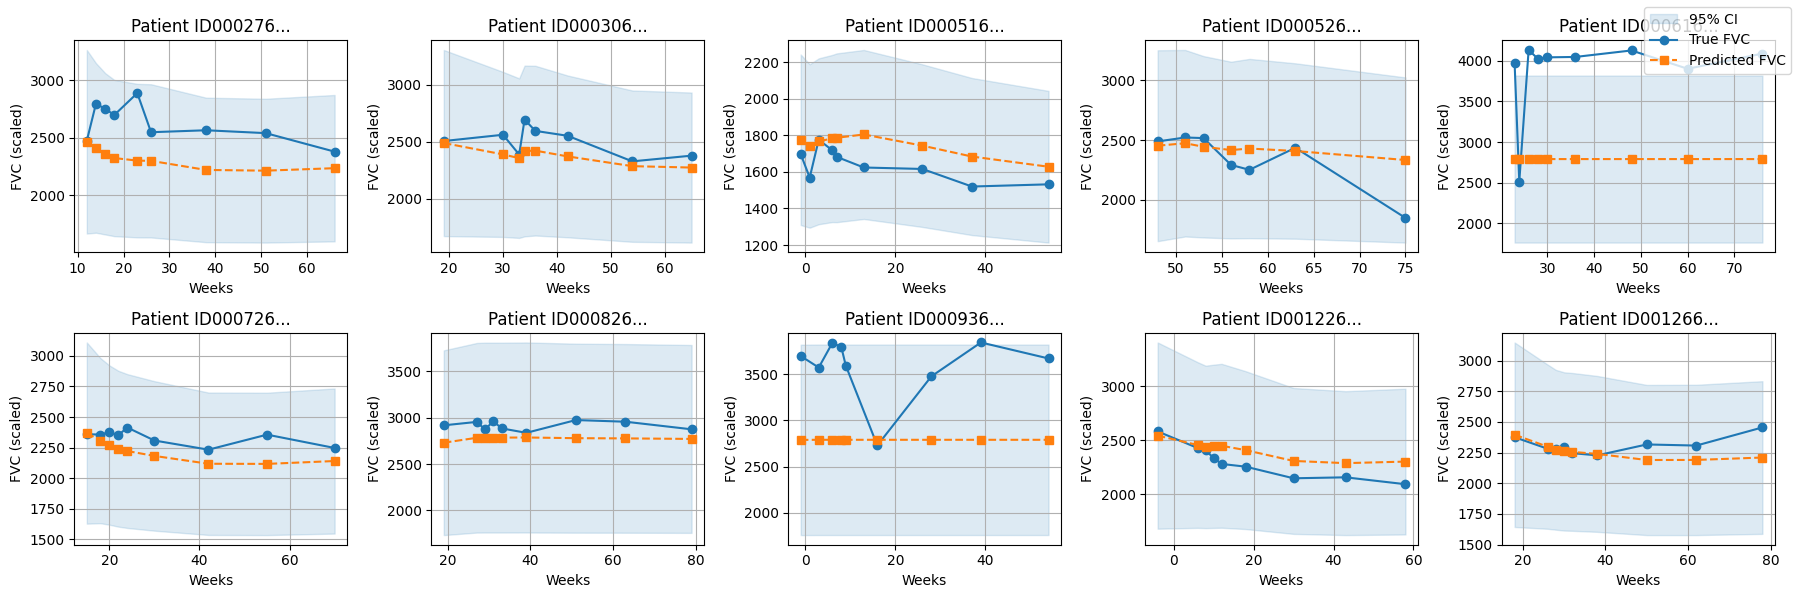

In [309]:
plot_grut_grid_M2(
    model=model2,
    dataset=val_dataset_M2,
    weeks_seqs= weeks_val_seqs_M2,
    patient_ids=val_patients_M2,
)


## Results and Interpretration

The results show that our GRU-T model (M1) performs strongly and generalizes well to unseen patients. On the training set, the model achieves an **MAE of approximately 149 mL** and an **R² of 0.94**, indicating that it captures the underlying temporal patterns in FVC effectively. Importantly, the validation performance is very close to the training performance, with an **MAE of about 143 mL** and an **R² of 0.89**. This small gap between training and validation metrics suggests that the model is not overfitting and remains stable when applied to new patient trajectories. The RMSE values in both sets are slightly higher than the MAE values, which is expected due to the inherent variability and noise present in clinical FVC measurements. Overall, the model demonstrates reliable predictive ability, achieving clinically reasonable error levels for the OSIC dataset and effectively learning disease progression patterns without sacrificing generalizability.

For M2, the Laplace log-likelihood scores for both the **training (−7.3647)** and **validation(−7.3300)** sets indicate that the model provides a relatively weak probabilistic fit, as less negative values generally correspond to better calibration of uncertainty. The **R² values (0.47 for training** and **0.46 for validation)** show that the model explains less than half of the variance in FVC, suggesting that its ability to capture underlying disease progression patterns is limited compared to stronger models. Although the training MAE is high at approximately 393 mL, the validation MAE is slightly lower at around 332 mL, which implies that there is no severe overfitting; however, both errors are significantly larger than clinically acceptable thresholds and much worse than typical GRU or Gaussian Process baselines for OSIC. Overall, these results suggest that the model struggles to learn meaningful temporal patterns, indicating the need for improved feature representation, better architecture choices, or more robust handling of irregular time intervals.

The performance gap between M1 and M2 is likely driven by differences in their underlying architectures, assumptions, input representations, and learning objectives. Several key factors contribute to this differences:

- Input preprocessing (scaled values in M1 vs. raw values in M2)
- Loss functions (MAE for direct error minimization vs. Laplace log-likelihood for probabilistic modeling)
- Training approaches (sequence-based learning in M1 vs. point-wise regression in M2)

Thus, we can hypothesise that M1 is specifically designed to capture temporal dependencies in each patient’s FVC trajectory, allowing it to model disease progression more effectively. In contrast, M2 uses a probabilistic regression framework with a Laplace likelihood and relies more on static or simplified inputs, limiting its ability to learn nuanced, irregular patterns across time. As a result, M1 may generally outperform M2 because its architecture is better suited for the sequential, irregular, and noisy time-series nature of our dataset.

To further improve our GRU-T model, we propose performing more systematic hyperparameter tuning using patient-level cross-validation rather than a single train/val split on parameters like number of layers, hidden size, which should give a more robust estimate of generalization and reduce variance. In addition, we can possibly enrich the input with additional temporal features through feature engineering. For instance, we may take local slopes into account. Since, we only focused on tabular data with GRU-T, we may extend further by incorparting with CT-scan data to take lung information into account. This multimodal approach could provide a more comprehensive representation of each patient and potentially improve predictive performance.